<a href="https://colab.research.google.com/github/stuckic/posCimatec/blob/main/Modelo_Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exercício de Machine Learning: Otimização de Métricas e Análise do Cut-off Point**    
Carlos Bastos Stucki

In [ ]:
!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 483.9/483.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 72.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 69.8 MB/s et

In [ ]:
import pandas as pd
import numpy as np
from pycaret.classification import *
#from pycaret.classification import predict_model, pull

# Objetivo:

O conjunto de dados são os registros da produtividade de soja (em quilogramas por hectare) ao longo de vários anos para diferentes municípios do Parana. Cada linha representa um município, e as colunas representam os anos, de 2004 a 2017

**O problema que vou resolver é:**
Previsão de Alta Produtividade: Definir uma classificação binária onde a meta é prever se um município terá alta produtividade (por exemplo, acima de um certo limiar) em um determinado ano. O limiar pode ser definido com base na mediana ou na média da produtividade de todos os municípios e anos.

# Métrica de Custo Personalizada

o custo de prever erroneamente um município como de alta produtividade quando não é (falso positivo) seja menor do que o custo de não identificar um município que realmente teria alta produtividade (falso negativo). Isso pode ser baseado na ideia de que um falso negativo pode resultar na perda de oportunidades de investimento ou suporte para melhorar ainda mais a produtividade, enquanto um falso positivo pode apenas resultar em alocação ineficiente de recursos, que, embora indesejável, é menos crítico.

Podemos então atribuir pesos a esses erros para refletir sua gravidade relativa. Por exemplo:

Custo por falso positivo (FP): 1 unidade de custo
Custo por falso negativo (FN): 5 unidades de custo
Com isso, a métrica de custo formulada como:

Custo Total=(FP×1)+(FN×5)



# Seleção de Conjunto de Dados:

In [ ]:
file_path = '/content/produtividade_soja.csv'

dados = pd.read_csv(file_path)

In [ ]:
# Preparação dos dados
# Transformar o conjunto de dados de wide (por ano) para long format

# conveter o dataframe para ter uma linha por município por ano
data_long = pd.melt(dados, id_vars=['nivel', 'codigo_ibge', 'name'], var_name='year', value_name='produtividade')

# Converter o ano para numérico
data_long['year'] = data_long['year'].astype(int)

# Calcular a mediana da produtividade por ano
median_produtivity_per_year = data_long.groupby('year')['produtividade'].median().reset_index()

# Adicionar a coluna de alta/baixa produtividade
data_long = data_long.merge(median_produtivity_per_year, on='year', suffixes=('', '_median'))
data_long['high_produtivity'] = (data_long['produtividade'] > data_long['produtividade_median']).astype(int)

In [ ]:
dados.describe()

,codigo_ibge,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
count,3.490000e+02,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000,349.000000
mean,4.114382e+06,2443.243553,2137.154728,2324.601719,2878.985673,2874.888252,2302.541547,3060.762178,3332.538682,2389.538682,3223.226361,2762.936963,3200.146132,3032.779370,3534.773639
std,8.310503e+03,491.598823,486.013397,492.378655,385.050821,353.336302,560.413206,262.148776,240.256381,601.327824,364.585070,634.056863,385.446910,441.840183,418.013010
min,4.100103e+06,1000.000000,900.000000,950.000000,1200.000000,1599.000000,146.000000,1934.000000,2400.000000,580.000000,2000.000000,1050.000000,1396.000000,1360.000000,1700.000000
25%,4.107256e+06,2200.000000,1823.000000,1992.000000,2700.000000,2680.000000,1925.000000,2924.000000,3200.000000,1994.000000,3014.000000,2334.000000,3000.000000,2800.000000,3400.000000
50%,4.114203e+06,2500.000000,2199.000000,2400.000000,2900.000000,2900.000000,2342.000000,3099.000000,3350.000000,2479.000000,3298.000000,2900.000000,3248.000000,3088.000000,3600.000000
75%,4.121604e+06,2750.000000,2500.000000,2699.000000,3075.000000,3100.000000,2700.000000,3200.000000,3486.000000,2820.000000,3455.000000,3209.000000,3450.000000,3350.000000,3800.000000
max,4.128708e+06,3600.000000,3400.000000,3470.000000,6988.000000,4300.000000,3471.000000,3741.000000,3800.000000,3572.000000,4000.000000,4031.000000,4008.000000,4159.000000,4515.000000


In [ ]:
class_setup = setup(data=data_long, target='high_produtivity', session_id=123,
            ignore_features=['nivel', 'codigo_ibge', 'name', 'produtividade_median'])

,Description,Value
0,Session id,123
1,Target,high_produtivity
2,Target type,Binary
3,Original data shape,"(4886, 7)"
4,Transformed data shape,"(4886, 3)"
5,Transformed train set shape,"(3420, 3)"
6,Transformed test set shape,"(1466, 3)"
7,Ignore features,4
8,Numeric features,2
9,Preprocess,True


In [ ]:
modelos = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9977,0.9996,0.9970,0.9982,0.9976,0.9953,0.9953,1.0380
dt,Decision Tree Classifier,0.9974,0.9973,0.9964,0.9982,0.9973,0.9947,0.9948,0.0550
xgboost,Extreme Gradient Boosting,0.9974,0.9999,0.9958,0.9988,0.9973,0.9947,0.9948,0.1310
rf,Random Forest Classifier,0.9971,0.9994,0.9964,0.9976,0.9970,0.9941,0.9942,0.2960
et,Extra Trees Classifier,0.9971,0.9999,0.9964,0.9976,0.9970,0.9941,0.9942,0.3870
gbc,Gradient Boosting Classifier,0.9953,0.9994,0.9964,0.9941,0.9952,0.9906,0.9907,0.2190
ada,Ada Boost Classifier,0.9327,0.9823,0.9324,0.9310,0.9313,0.8654,0.8662,0.1570
knn,K Neighbors Classifier,0.8743,0.9482,0.8816,0.8644,0.8726,0.7485,0.7492,0.0940
qda,Quadratic Discriminant Analysis,0.7532,0.8711,0.8588,0.7027,0.7728,0.5086,0.5214,0.0310
ridge,Ridge Classifier,0.7526,0.0000,0.8307,0.7122,0.7665,0.5068,0.5143,0.0270


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

Suponha que o custo de prever erroneamente um município como de alta produtividade quando não é (falso positivo) seja menor do que o custo de não identificar um município que realmente teria alta produtividade (falso negativo). Isso pode ser baseado na ideia de que um falso negativo pode resultar na perda de oportunidades de investimento ou suporte para melhorar ainda mais a produtividade, enquanto um falso positivo pode apenas resultar em alocação ineficiente de recursos, que, embora indesejável, é menos crítico.

Podemos então atribuir pesos a esses erros para refletir sua gravidade relativa. Por exemplo:

Custo por falso positivo (FP): 1 unidade de custo
Custo por falso negativo (FN): 5 unidades de custo
Com isso, a métrica de custo poderia ser formulada como:

Custo Total
=
(
FP
×
1
)
+
(
FN
×
5
)
Custo Total=(FP×1)+(FN×5)

Esta é uma função que podemos querer minimizar.

In [ ]:
# Criando uma métrica personalizada no PyCaret
from pycaret.classification import add_metric, get_metrics, remove_metric


# Definição da função de custo
def custo(y, y_pred):
    vp = np.where((y_pred == 1) & (y == 1), 1, 0)
    fp = np.where((y_pred == 1) & (y == 0), 2, 0)
    fn = np.where((y_pred == 0) & (y == 1), 5, 0)
    return np.sum([vp, fp, fn])/len(y)

# Verificar se a métrica 'custo' já existe e removê-la se existir
existing_metrics = get_metrics()
if 'custo' in existing_metrics:
    remove_metric('custo')

# Adicionar a métrica ao PyCaret
add_metric(id='custo', name='Custo', score_func=custo, greater_is_better=False)

Name                                                             Custo
Display Name                                                     Custo
Score Function       <pycaret.internal.metrics.EncodedDecodedLabels...
Scorer                     make_scorer(custo, greater_is_better=False)
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: custo, dtype: object

In [ ]:
modelos = compare_models(sort = 'Custo')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo,TT (Sec)
lr,Logistic Regression,0.7193,0.8073,0.7512,0.6982,0.7236,0.4392,0.4407,0.0000,0.6930
knn,K Neighbors Classifier,0.8743,0.9482,0.8816,0.8644,0.8726,0.7485,0.7492,0.0000,0.0560
nb,Naive Bayes,0.6889,0.8091,0.7919,0.6495,0.7135,0.3804,0.3895,0.0000,0.0330
dt,Decision Tree Classifier,0.9974,0.9973,0.9964,0.9982,0.9973,0.9947,0.9948,0.0000,0.0310
svm,SVM - Linear Kernel,0.6240,0.0000,0.5662,0.6677,0.4882,0.2439,0.3098,0.0000,0.0460
ridge,Ridge Classifier,0.7526,0.0000,0.8307,0.7122,0.7665,0.5068,0.5143,0.0000,0.0300
rf,Random Forest Classifier,0.9971,0.9994,0.9964,0.9976,0.9970,0.9941,0.9942,0.0000,0.3800
qda,Quadratic Discriminant Analysis,0.7532,0.8711,0.8588,0.7027,0.7728,0.5086,0.5214,0.0000,0.0550
ada,Ada Boost Classifier,0.9327,0.9823,0.9324,0.9310,0.9313,0.8654,0.8662,0.0000,0.2810
gbc,Gradient Boosting Classifier,0.9953,0.9994,0.9964,0.9941,0.9952,0.9906,0.9907,0.0000,0.3470


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

LightGBM, Decision Tree, e Random Forest mostram os melhores resultados em termos de precisão (Accuracy), AUC, Recall, Precisão (Prec.), F1, Kappa, MCC e Custo.
Um valor menor para a métrica 'Custo' é melhor. Isso significa que o modelo Light Gradient Boosting Machine (LightGBM) tem o menor custo, seguido de perto pelo Decision Tree e Random Forest.

In [ ]:
lightgbm = create_model('lightgbm')
lightgbm_tunado = tune_model(lightgbm, optimize = 'Custo')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
Fold,,,,,,,,
0,0.9971,1.0000,0.9940,1.0000,0.9970,0.9941,0.9942,-0.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,-0.0000
2,0.9942,0.9999,0.9940,0.9940,0.9940,0.9883,0.9883,-0.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,-0.0000
4,0.9912,0.9967,0.9880,0.9940,0.9910,0.9824,0.9825,-0.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,-0.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,-0.0000
7,0.9971,1.0000,0.9940,1.0000,0.9970,0.9941,0.9942,-0.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,-0.0000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
Fold,,,,,,,,
0,0.5088,0.9757,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000
1,0.5088,0.9579,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000
2,0.5117,0.9373,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000
3,0.5117,0.9686,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000
4,0.5117,0.9544,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000
5,0.5117,0.9592,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000
6,0.5117,0.9402,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000
7,0.5117,0.9331,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000
8,0.5117,0.9469,0.0000,0.0000,0.0000,0.0000,0.0000,-0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [ ]:
dt = create_model('dt')
dt_tunado = tune_model(dt, optimize = 'Custo')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
Fold,,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,-0.0000
1,0.9971,0.9970,0.9940,1.0000,0.9970,0.9941,0.9942,-0.0000
2,0.9971,0.9971,1.0000,0.9940,0.9970,0.9941,0.9942,-0.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,-0.0000
4,0.9942,0.9940,0.9880,1.0000,0.9940,0.9883,0.9884,-0.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,-0.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,-0.0000
7,0.9912,0.9910,0.9820,1.0000,0.9909,0.9824,0.9826,-0.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,-0.0000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
Fold,,,,,,,,
0,0.6754,0.6807,0.9821,0.6044,0.7483,0.3576,0.4503,-0.0000
1,0.6608,0.6664,0.9821,0.5935,0.7399,0.3290,0.4265,-0.0000
2,0.6696,0.6767,0.9820,0.5985,0.7438,0.3484,0.4427,-0.0000
3,0.6871,0.6937,0.9760,0.6128,0.7529,0.3823,0.4659,-0.0000
4,0.6725,0.6792,0.9641,0.6030,0.7419,0.3535,0.4329,-0.0000
5,0.6871,0.6937,0.9760,0.6128,0.7529,0.3823,0.4659,-0.0000
6,0.7047,0.7113,0.9940,0.6241,0.7667,0.4169,0.5081,-0.0000
7,0.6842,0.6909,0.9760,0.6105,0.7512,0.3766,0.4612,-0.0000
8,0.6754,0.6719,0.5210,0.7373,0.6105,0.3461,0.3615,-0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [ ]:
rf = create_model('rf')
rf_tunado = tune_model(rf, optimize = 'Custo')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
Fold,,,,,,,,
0,0.9942,0.9998,0.9881,1.0000,0.9940,0.9883,0.9884,-0.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,-0.0000
2,0.9912,0.9996,1.0000,0.9824,0.9911,0.9825,0.9826,-0.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,-0.0000
4,0.9912,0.9952,0.9820,1.0000,0.9909,0.9824,0.9826,-0.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,-0.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,-0.0000
7,0.9971,1.0000,0.9940,1.0000,0.9970,0.9941,0.9942,-0.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,-0.0000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
Fold,,,,,,,,
0,0.8918,0.9831,0.9167,0.8701,0.8928,0.7838,0.7848,-0.0000
1,0.9094,0.9783,0.8929,0.9202,0.9063,0.8186,0.8189,-0.0000
2,0.9181,0.9789,0.9162,0.9162,0.9162,0.8362,0.8362,-0.0000
3,0.9152,0.9839,0.9521,0.8833,0.9164,0.8306,0.8330,-0.0000
4,0.9123,0.9824,0.9401,0.8870,0.9128,0.8247,0.8261,-0.0000
5,0.9181,0.9863,0.9521,0.8883,0.9191,0.8364,0.8385,-0.0000
6,0.9094,0.9813,0.8982,0.9146,0.9063,0.8185,0.8187,-0.0000
7,0.9181,0.9811,0.8982,0.9317,0.9146,0.8360,0.8365,-0.0000
8,0.9152,0.9836,0.8922,0.9312,0.9113,0.8302,0.8309,-0.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [ ]:
modelo_exemplo = lightgbm_tunado

# Previsão usando um ponto de corte de exemplo
predict_model(modelo_exemplo, probability_threshold=0.5)

# Puxar o DataFrame de métricas e imprimi-lo
metricas = pull()
print(metricas)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Light Gradient Boosting Machine,0.9973,0.9998,0.9944,1.0000,0.9972,0.9945,0.9946,0


                             Model  Accuracy     AUC  Recall  Prec.      F1  \
0  Light Gradient Boosting Machine    0.9973  0.9998  0.9944    1.0  0.9972   

    Kappa     MCC  Custo  
0  0.9945  0.9946      0  


In [ ]:
# Modelos tunados
modelos_tunados = [lightgbm_tunado, dt_tunado, rf_tunado]

# Definindo os pontos de corte
cortes = np.arange(0.05, 1, 0.05)

# Dicionário para armazenar os resultados
resultados = {}

# Iterar sobre os modelos
for modelo in modelos_tunados:
    rec = []
    pre = []
    cus = []

    # Iterar sobre os pontos de corte
    for corte in cortes:
        predictions = predict_model(modelo, probability_threshold=float(corte))
        metricas = pull()

        # Extrair as métricas necessárias
        rec.append(metricas.loc[0, 'Recall'])
        pre.append(metricas.loc[0, 'Prec.'])
        cus.append(metricas.loc[0, 'Custo'])

    # Armazenar os resultados em um DataFrame
    resultados[modelo.__class__.__name__] = pd.DataFrame({'Corte': cortes, 'Recall': rec, 'Precisão': pre, 'Custo': cus})

# Exibir os resultados
for modelo, df in resultados.items():
    print(f"Resultados para {modelo}:")
    print(df)
    print("\n")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Light Gradient Boosting Machine,0.9973,0.9998,0.9944,1.0000,0.9972,0.9945,0.9946,0.4993


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Light Gradient Boosting Machine,0.9973,0.9998,0.9944,1.0000,0.9972,0.9945,0.9946,0.4993


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Light Gradient Boosting Machine,0.9973,0.9998,0.9944,1.0000,0.9972,0.9945,0.9946,0.4993


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Light Gradient Boosting Machine,0.9973,0.9998,0.9944,1.0000,0.9972,0.9945,0.9946,0.4993


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Light Gradient Boosting Machine,0.9973,0.9998,0.9944,1.0000,0.9972,0.9945,0.9946,0.4993


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Light Gradient Boosting Machine,0.9973,0.9998,0.9944,1.0000,0.9972,0.9945,0.9946,0.4993


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Light Gradient Boosting Machine,0.9973,0.9998,0.9944,1.0000,0.9972,0.9945,0.9946,0.4993


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Light Gradient Boosting Machine,0.9973,0.9998,0.9944,1.0000,0.9972,0.9945,0.9946,0.4993


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Light Gradient Boosting Machine,0.9973,0.9998,0.9944,1.0000,0.9972,0.9945,0.9946,0.4993


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Light Gradient Boosting Machine,0.9973,0.9998,0.9944,1.0000,0.9972,0.9945,0.9946,0.4993


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Light Gradient Boosting Machine,0.9973,0.9998,0.9944,1.0000,0.9972,0.9945,0.9946,0.4993


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Light Gradient Boosting Machine,0.9973,0.9998,0.9944,1.0000,0.9972,0.9945,0.9946,0.4993


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Light Gradient Boosting Machine,0.9973,0.9998,0.9944,1.0000,0.9972,0.9945,0.9946,0.4993


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Light Gradient Boosting Machine,0.9973,0.9998,0.9944,1.0000,0.9972,0.9945,0.9946,0.4993


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Light Gradient Boosting Machine,0.9973,0.9998,0.9944,1.0000,0.9972,0.9945,0.9946,0.4993


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Light Gradient Boosting Machine,0.9973,0.9998,0.9944,1.0000,0.9972,0.9945,0.9946,0.4993


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Light Gradient Boosting Machine,0.9973,0.9998,0.9944,1.0000,0.9972,0.9945,0.9946,0.4993


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Light Gradient Boosting Machine,0.9973,0.9998,0.9944,1.0000,0.9972,0.9945,0.9946,0.4993


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Light Gradient Boosting Machine,0.9973,0.9998,0.9944,1.0000,0.9972,0.9945,0.9946,0.4993


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Decision Tree Classifier,0.9966,0.9965,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Decision Tree Classifier,0.9966,0.9965,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Decision Tree Classifier,0.9966,0.9965,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Decision Tree Classifier,0.9966,0.9965,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Decision Tree Classifier,0.9966,0.9965,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Decision Tree Classifier,0.9966,0.9965,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Decision Tree Classifier,0.9966,0.9965,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Decision Tree Classifier,0.9966,0.9965,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Decision Tree Classifier,0.9966,0.9965,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Decision Tree Classifier,0.9966,0.9965,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Decision Tree Classifier,0.9966,0.9965,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Decision Tree Classifier,0.9966,0.9965,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Decision Tree Classifier,0.9966,0.9965,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Decision Tree Classifier,0.9966,0.9965,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Decision Tree Classifier,0.9966,0.9965,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Decision Tree Classifier,0.9966,0.9965,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Decision Tree Classifier,0.9966,0.9965,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Decision Tree Classifier,0.9966,0.9965,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Decision Tree Classifier,0.9966,0.9965,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Random Forest Classifier,0.9366,0.9982,0.9972,0.8870,0.9389,0.8734,0.8799,0.6180


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Random Forest Classifier,0.9714,0.9982,0.9972,0.9469,0.9714,0.9427,0.9440,0.5484


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Random Forest Classifier,0.9829,0.9982,0.9958,0.9701,0.9828,0.9659,0.9662,0.5266


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Random Forest Classifier,0.9898,0.9982,0.9944,0.9848,0.9896,0.9795,0.9796,0.5143


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Random Forest Classifier,0.9911,0.9982,0.9944,0.9875,0.9910,0.9823,0.9823,0.5116


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Random Forest Classifier,0.9932,0.9982,0.9944,0.9916,0.9930,0.9864,0.9864,0.5075


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Random Forest Classifier,0.9966,0.9982,0.9944,0.9986,0.9965,0.9932,0.9932,0.5007


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Random Forest Classifier,0.9966,0.9982,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Random Forest Classifier,0.9966,0.9982,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Random Forest Classifier,0.9966,0.9982,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Random Forest Classifier,0.9966,0.9982,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Random Forest Classifier,0.9952,0.9982,0.9902,1.0000,0.9951,0.9904,0.9905,0.5075


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Random Forest Classifier,0.9945,0.9982,0.9888,1.0000,0.9944,0.9891,0.9891,0.5102


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Random Forest Classifier,0.9939,0.9982,0.9874,1.0000,0.9937,0.9877,0.9878,0.5130


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Random Forest Classifier,0.9932,0.9982,0.9860,1.0000,0.9930,0.9863,0.9864,0.5157


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Random Forest Classifier,0.9905,0.9982,0.9804,1.0000,0.9901,0.9809,0.9811,0.5266


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Random Forest Classifier,0.9850,0.9982,0.9693,1.0000,0.9844,0.9699,0.9704,0.5484


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Random Forest Classifier,0.9809,0.9982,0.9609,1.0000,0.9801,0.9617,0.9625,0.5648


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Random Forest Classifier,0.9516,0.9982,0.9008,1.0000,0.9478,0.9029,0.9072,0.6821


Resultados para LGBMClassifier:
    Corte  Recall  Precisão   Custo
0    0.05  0.9944       1.0  0.4993
1    0.10  0.9944       1.0  0.4993
2    0.15  0.9944       1.0  0.4993
3    0.20  0.9944       1.0  0.4993
4    0.25  0.9944       1.0  0.4993
5    0.30  0.9944       1.0  0.4993
6    0.35  0.9944       1.0  0.4993
7    0.40  0.9944       1.0  0.4993
8    0.45  0.9944       1.0  0.4993
9    0.50  0.9944       1.0  0.4993
10   0.55  0.9944       1.0  0.4993
11   0.60  0.9944       1.0  0.4993
12   0.65  0.9944       1.0  0.4993
13   0.70  0.9944       1.0  0.4993
14   0.75  0.9944       1.0  0.4993
15   0.80  0.9944       1.0  0.4993
16   0.85  0.9944       1.0  0.4993
17   0.90  0.9944       1.0  0.4993
18   0.95  0.9944       1.0  0.4993


Resultados para DecisionTreeClassifier:
    Corte  Recall  Precisão  Custo
0    0.05   0.993       1.0  0.502
1    0.10   0.993       1.0  0.502
2    0.15   0.993       1.0  0.502
3    0.20   0.993       1.0  0.502
4    0.25   0.993       1.0  0.

In [ ]:
pull().loc[0, 'Custo']

0.6821

In [ ]:
modelos

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
modelos = compare_models(n_select = 18)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9977,0.9996,0.9970,0.9982,0.9976,0.9953,0.9953,0.4965,0.3850
dt,Decision Tree Classifier,0.9974,0.9973,0.9964,0.9982,0.9973,0.9947,0.9948,0.4977,0.0330
xgboost,Extreme Gradient Boosting,0.9974,0.9999,0.9958,0.9988,0.9973,0.9947,0.9948,0.4982,0.0710
rf,Random Forest Classifier,0.9971,0.9994,0.9964,0.9976,0.9970,0.9941,0.9942,0.4982,0.3740
et,Extra Trees Classifier,0.9971,0.9999,0.9964,0.9976,0.9970,0.9941,0.9942,0.4982,0.2380
gbc,Gradient Boosting Classifier,0.9953,0.9994,0.9964,0.9941,0.9952,0.9906,0.9907,0.5018,0.3980
ada,Ada Boost Classifier,0.9327,0.9823,0.9324,0.9310,0.9313,0.8654,0.8662,0.6895,0.2870
knn,K Neighbors Classifier,0.8743,0.9482,0.8816,0.8644,0.8726,0.7485,0.7492,0.8561,0.0530
qda,Quadratic Discriminant Analysis,0.7532,0.8711,0.8588,0.7027,0.7728,0.5086,0.5214,1.1205,0.0890
ridge,Ridge Classifier,0.7526,0.0000,0.8307,0.7122,0.7665,0.5068,0.5143,1.1491,0.0310


Processing:   0%|          | 0/79 [00:00<?, ?it/s]

# Combinação de Modelos

In [ ]:
combinado1 = blend_models([modelos[0], modelos[1], modelos[2]], method = 'hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
Fold,,,,,,,,
0,0.9971,0.0000,0.9940,1.0000,0.9970,0.9941,0.9942,0.5029
1,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4912
2,0.9942,0.0000,0.9940,0.9940,0.9940,0.9883,0.9883,0.5058
3,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4883
4,0.9912,0.0000,0.9820,1.0000,0.9909,0.9824,0.9826,0.5234
5,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4883
6,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4883
7,0.9971,0.0000,0.9940,1.0000,0.9970,0.9941,0.9942,0.5000
8,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4883


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
combinado2 = blend_models([modelos[0], modelos[5], modelos[11]], method = 'hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
Fold,,,,,,,,
0,0.9971,0.0000,0.9940,1.0000,0.9970,0.9941,0.9942,0.5029
1,0.9971,0.0000,0.9940,1.0000,0.9970,0.9941,0.9942,0.5029
2,0.9971,0.0000,1.0000,0.9940,0.9970,0.9941,0.9942,0.4942
3,0.9971,0.0000,1.0000,0.9940,0.9970,0.9941,0.9942,0.4942
4,0.9912,0.0000,0.9880,0.9940,0.9910,0.9824,0.9825,0.5175
5,0.9942,0.0000,0.9940,0.9940,0.9940,0.9883,0.9883,0.5058
6,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4883
7,0.9942,0.0000,0.9880,1.0000,0.9940,0.9883,0.9884,0.5117
8,0.9971,0.0000,1.0000,0.9940,0.9970,0.9941,0.9942,0.4942


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
combinado2 = blend_models([modelos[1], modelos[4], modelos[8]], method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
Fold,,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4912
1,0.9971,1.0000,0.9940,1.0000,0.9970,0.9941,0.9942,0.5029
2,0.9942,1.0000,1.0000,0.9882,0.9940,0.9883,0.9884,0.5000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4883
4,0.9942,0.9984,0.9880,1.0000,0.9940,0.9883,0.9884,0.5117
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4883
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4883
7,0.9912,0.9985,0.9820,1.0000,0.9909,0.9824,0.9826,0.5234
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4883


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
combinado3 = blend_models([modelos[0], modelos[1], modelos[6]], method = 'hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
Fold,,,,,,,,
0,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4912
1,0.9971,0.0000,0.9940,1.0000,0.9970,0.9941,0.9942,0.5029
2,0.9942,0.0000,1.0000,0.9882,0.9940,0.9883,0.9884,0.5000
3,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4883
4,0.9912,0.0000,0.9880,0.9940,0.9910,0.9824,0.9825,0.5175
5,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4883
6,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4883
7,0.9912,0.0000,0.9820,1.0000,0.9909,0.9824,0.9826,0.5234
8,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4883


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
combinado3s = blend_models([modelos[0], modelos[1], modelos[6]], method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
Fold,,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4912
1,0.9971,1.0000,0.9940,1.0000,0.9970,0.9941,0.9942,0.5029
2,0.9971,1.0000,1.0000,0.9940,0.9970,0.9941,0.9942,0.4942
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4883
4,0.9942,0.9999,0.9880,1.0000,0.9940,0.9883,0.9884,0.5117
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4883
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4883
7,0.9912,0.9974,0.9820,1.0000,0.9909,0.9824,0.9826,0.5234
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,0.4883


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

# Análise do Cut-off Point:

In [ ]:
cortes = np.arange(0.05, 1, 0.05)
print(cortes)

rec = []
pre = []
cus = []

for corte in cortes:
    predict_model(combinado3s, probability_threshold = float(corte))
    metricas = pull()
    rec.append(metricas.loc[0, 'Recall'])
    pre.append(metricas.loc[0, 'Prec.'])
    cus.append(metricas.loc[0, 'Custo'])

import pandas as pd
pd.DataFrame({'Corte': cortes, 'Recall': rec, 'Precisão': pre, 'Custo': cus})


[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95]


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Voting Classifier,0.4884,0.9993,1.0000,0.4884,0.6563,0.0000,0.0000,1.5116


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Voting Classifier,0.5061,0.9993,1.0000,0.4972,0.6642,0.0339,0.1313,1.4761


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Voting Classifier,0.6630,0.9993,1.0000,0.5917,0.7435,0.3361,0.4494,1.1623


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Voting Classifier,0.9973,0.9993,0.9944,1.0000,0.9972,0.9945,0.9946,0.4993


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Voting Classifier,0.9973,0.9993,0.9944,1.0000,0.9972,0.9945,0.9946,0.4993


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Voting Classifier,0.9973,0.9993,0.9944,1.0000,0.9972,0.9945,0.9946,0.4993


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Voting Classifier,0.9973,0.9993,0.9944,1.0000,0.9972,0.9945,0.9946,0.4993


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Voting Classifier,0.9973,0.9993,0.9944,1.0000,0.9972,0.9945,0.9946,0.4993


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Voting Classifier,0.9973,0.9993,0.9944,1.0000,0.9972,0.9945,0.9946,0.4993


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Voting Classifier,0.9973,0.9993,0.9944,1.0000,0.9972,0.9945,0.9946,0.4993


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Voting Classifier,0.9966,0.9993,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Voting Classifier,0.9966,0.9993,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Voting Classifier,0.9966,0.9993,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Voting Classifier,0.9966,0.9993,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Voting Classifier,0.9966,0.9993,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Voting Classifier,0.9966,0.9993,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Voting Classifier,0.6583,0.9993,0.3003,1.0000,0.4619,0.3051,0.4243,1.8554


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Voting Classifier,0.5457,0.9993,0.0698,1.0000,0.1305,0.0713,0.1923,2.3056


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Voting Classifier,0.5116,0.9993,0.0000,0.0000,0.0000,0.0000,0.0000,2.4420


,Corte,Recall,Precisão,Custo
0,0.05,1.0000,0.4884,1.5116
1,0.10,1.0000,0.4972,1.4761
2,0.15,1.0000,0.5917,1.1623
3,0.20,0.9944,1.0000,0.4993
4,0.25,0.9944,1.0000,0.4993
5,0.30,0.9944,1.0000,0.4993
6,0.35,0.9944,1.0000,0.4993
7,0.40,0.9944,1.0000,0.4993
8,0.45,0.9944,1.0000,0.4993
9,0.50,0.9944,1.0000,0.4993


# Justificativa para escolha do ponto de corte:

Os pontos de corte variam de 0.05 a 0.95, e os resultados mostram diferentes métricas de Recall, Precisão e Custo. O Recall permanece perfeito (1.0000) até o ponto de corte de 0.15, onde começa a diminuir levemente. A Precisão, por outro lado, é perfeita (1.0000) em todos os pontos de corte de 0.20 em diante. O Custo é mínimo (0.4993) para os pontos de corte de 0.20 até 0.50, depois começa a aumentar ligeiramente para 0.5020 e aumenta drasticamente depois do ponto de corte de 0.80.


Dado que o Custo é uma consideração importante para manter tanto a Precisão quanto o Recall altos, o ponto de corte de 0.20 parece ser o melhor equilíbrio. Este ponto oferece alta Precisão e Recall com o menor Custo possível. Isso significa que o modelo está identificando corretamente a maioria dos municípios de alta produtividade sem incorrer em custos desnecessários por classificações incorretas.

In [ ]:
# Criar o modelo de Regressão Logística
lr_model = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
Fold,,,,,,,,
0,0.7047,0.8005,0.7619,0.6772,0.7171,0.4104,0.4136,1.3158
1,0.6842,0.7851,0.7381,0.6596,0.6966,0.3695,0.3721,1.3801
2,0.7222,0.8030,0.7605,0.6978,0.7278,0.4453,0.4470,1.2778
3,0.7515,0.8514,0.7844,0.7278,0.7550,0.5035,0.5050,1.1959
4,0.7193,0.8053,0.7305,0.7052,0.7176,0.4388,0.4390,1.3129
5,0.7456,0.8235,0.7725,0.7247,0.7478,0.4917,0.4927,1.2193
6,0.7339,0.8188,0.7425,0.7209,0.7316,0.4679,0.4681,1.2719
7,0.6930,0.7892,0.7246,0.6722,0.6974,0.3867,0.3878,1.3713
8,0.7135,0.7963,0.7186,0.7018,0.7101,0.4269,0.4270,1.3363


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
# Otimizar o modelo de Regressão Logística
lr_tunado = tune_model(lr_model, optimize = 'Custo')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
Fold,,,,,,,,
0,0.7047,0.8005,0.7619,0.6772,0.7171,0.4104,0.4136,1.3158
1,0.6842,0.7851,0.7381,0.6596,0.6966,0.3695,0.3721,1.3801
2,0.7222,0.8030,0.7605,0.6978,0.7278,0.4453,0.4470,1.2778
3,0.7515,0.8514,0.7844,0.7278,0.7550,0.5035,0.5050,1.1959
4,0.7193,0.8053,0.7305,0.7052,0.7176,0.4388,0.4390,1.3129
5,0.7456,0.8235,0.7725,0.7247,0.7478,0.4917,0.4927,1.2193
6,0.7339,0.8188,0.7425,0.7209,0.7316,0.4679,0.4681,1.2719
7,0.6930,0.7892,0.7246,0.6722,0.6974,0.3867,0.3878,1.3713
8,0.7135,0.7963,0.7186,0.7018,0.7101,0.4269,0.4270,1.3363


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


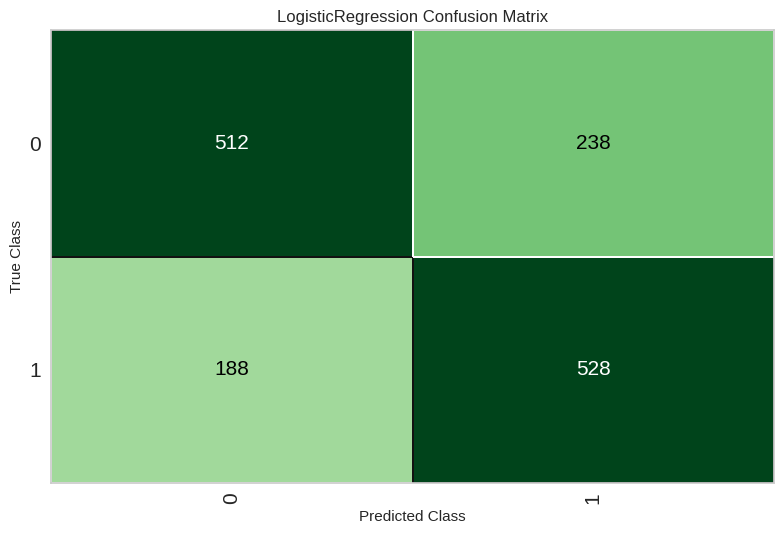

In [ ]:
# Avaliar o desempenho do modelo otimizado
evaluate_model(lr_tunado)

In [ ]:
# Comparar o modelo de Regressão Logística otimizado com outros modelos
all_models = [lr_tunado, lightgbm_tunado, dt_tunado, rf_tunado]
for model in all_models:
    print(f"Desempenho do modelo {model.__class__.__name__}:")
    pred = predict_model(model)
    custo_model = pull().loc[0, 'Custo']
    print(f"Custo: {custo_model}\n")

Desempenho do modelo LogisticRegression:


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Logistic Regression,0.7094,0.8043,0.7374,0.6893,0.7126,0.4194,0.4204,1.3261


Custo: 1.3261

Desempenho do modelo LGBMClassifier:


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Light Gradient Boosting Machine,0.9973,0.9998,0.9944,1.0000,0.9972,0.9945,0.9946,0.4993


Custo: 0.4993

Desempenho do modelo DecisionTreeClassifier:


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Decision Tree Classifier,0.9966,0.9965,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


Custo: 0.502

Desempenho do modelo RandomForestClassifier:


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Custo
0,Random Forest Classifier,0.9966,0.9982,0.9930,1.0000,0.9965,0.9932,0.9932,0.5020


Custo: 0.502



# Análise dos Resultados
**Desempenho da Regressão Logística:**

O modelo de Regressão Logística apresentou um custo de 1.3261, que é significativamente mais alto do que os outros modelos (LightGBM, Decision Tree, Random Forest).
Isso indica que, enquanto a Regressão Logística é um modelo mais simples e interpretável, ela pode não ser tão eficaz quanto os modelos mais complexos no contexto específico do seu conjunto de dados.

**Comparação com Outros Modelos:**

Os modelos LightGBM, Decision Tree e Random Forest mostraram um custo muito menor (aproximadamente 0.50), indicando um desempenho superior em termos de minimizar a métrica de custo personalizada.
Esses modelos mais complexos podem estar capturando nuances no conjunto de dados que a Regressão Logística não consegue, o que é comum em conjuntos de dados com relações não-lineares ou interações complexas entre as variáveis.



---





---

